In this notebook we will demonstrate how we build the histograms of the individual masses of the OCs. This histogram is used to calculate the mass function of each cluster through a segmented function and with the aid of the segmented_linear  function to determine the best parameters (alpha high, alpha low and Mc).

We will use Pleiades (Melotte_22), in which the memberships with their individual masses can be downloaded from GitHub or through our Dashboard:

🔸 GitHub: https://github.com/ander-son-almeida/DashboardOCmass/tree/main/data/membership_data_edr3

🔸 Dashboard: https://ocmass.streamlit.app/Integrated_MF

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st
from scipy.optimize import curve_fit

In [56]:
#read membership_data
name = 'Melotte_22' #Pleiades
data_obs = np.load('Melotte_22.npy')

In [57]:
# function to fit IMF - segmented function
def segmented_linear(logm, logMc=0., slopeA=0., offsetA=1., slopeB=-1.0):
    res = []
    for val in logm:
        if val > logMc:
            res.append(slopeA * val + offsetA)
        else:
            t1 = slopeA * logMc + offsetA
            t2 = slopeB * logMc
            dt = t1-t2
            res.append(slopeB * val + dt)
    return np.array(res) 

In [58]:
# extrapolation for white dwarfs
# https://ui.adsabs.harvard.edu/abs/2018ApJ...866...21C/abstract    
def MFR(initial_mass):
    Mf = np.zeros(initial_mass.size)
    for i,mi in enumerate(initial_mass):
        if (mi > 0.87 and mi < 2.8):
            Mf[i] = 0.0873*mi + 0.476
        elif (mi >= 2.8 and mi < 3.65):
            Mf[i] = 0.181*mi + 0.21
        elif (mi >= 3.65 and mi < 8.2):
            Mf[i] = 0.0835*mi + 0.565
    return Mf

In [59]:
def fit_MF(mass, title_str=''):
    
    # histogram IMF
    #######################################################################
    mass = np.log10(mass[mass > 0.])
    mass_cnt, mass_bins = np.histogram(mass,bins='auto')
    mass_cnt_er = np.sqrt(mass_cnt)
    mass_cnt_er = ((mass_cnt_er/mass_cnt)/2.303)    
    mass_cnt = np.log10(mass_cnt)
    mass_bin_ctr = mass_bins[:-1] + np.diff(mass_bins)/2
    mass_bin_ctr = mass_bin_ctr[mass_cnt >= 0]
    mass_cnt_er = mass_cnt_er[mass_cnt >= 0]
    mass_cnt = mass_cnt[mass_cnt >= 0]

    #applying curve_fit in the segmented function
    #######################################################################
    guess = [0.02,-1.1, 1.1, 0.3]
    popt, pcov = curve_fit(segmented_linear, mass_bin_ctr, mass_cnt, p0=guess, 
                        sigma=mass_cnt_er,max_nfev=1e5,
                        bounds=([-0.2, -3, 0., 0.01], [0.2, 0.0, np.inf, 3.0]),
                            )
    
    #coefficients    
    Mc = popt[0]
    alpha_high_mass = popt[1]
    offset = popt[2]
    alpha_low_mass = popt[3]
    
    # errors
    sigma = np.sqrt(np.diag(pcov))
    Mc_error = sigma[0]
    alpha_high_mass_error = sigma[1]
    offset_error = sigma[2]
    alpha_low_mass_error = sigma[3]

    # extrapolation 
    #######################################################################
    mass_pts = np.arange(np.log10(0.09),mass_bin_ctr.min(),np.diff(mass_bin_ctr)[0])
    Nstars = segmented_linear(mass_pts, Mc, alpha_high_mass, offset, alpha_low_mass) 
    
    # total mass not visible
    inv_mass = (np.sum(10**mass_pts * 10**Nstars))
        
    mass_pts = np.arange(mass_bin_ctr.max(), np.log10(7.5),np.diff(mass_bin_ctr)[0])
    Nstars = segmented_linear(mass_pts, Mc, alpha_high_mass, offset, alpha_low_mass) 
    
    # total mass in WDs
    inv_mass_wd = (np.sum(MFR(10**mass_pts) * 10**Nstars))

    return alpha_high_mass, alpha_low_mass, Mc, offset, alpha_high_mass_error, \
        alpha_low_mass_error, Mc_error, offset_error, mass_cnt, mass_cnt_er, \
        mass_bin_ctr, inv_mass, inv_mass_wd, popt

This demo focuses on MF integrated, where we concatenate all populations: individual stars and binary stars with the mass of their companions.

In [60]:
mass_intergrated = np.concatenate((data_obs['mass'],data_obs['comp_mass']), axis=0)

alpha_high_int, alpha_low_int, Mc_int, offset_int, alpha_high_er_int, \
alpha_low_er_int, Mc_er_int, offset_er_int, mass_cnt_int, mass_cnt_er_int, \
mass_bin_ctr_int, inv_mass_sing_int, inv_mass_wd_sing_int, popt_int = fit_MF(mass_intergrated,'Integrated')

title = name + '(Pleiades)' +'\n 'r'$\alpha_A = {} \pm {}$; $\alpha_B = {} \pm {}$; $M_c = {} \pm {}$'

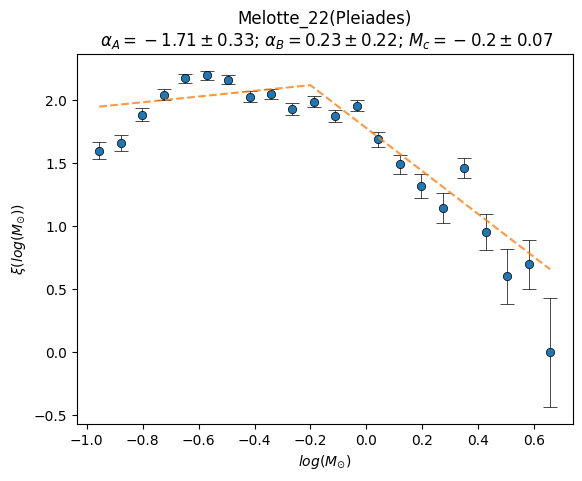

In [61]:
# graphic MF

fig = plt.figure()
ax = plt.axes()
ax.errorbar(mass_bin_ctr_int, mass_cnt_int, yerr = mass_cnt_er_int, fmt='o', capsize=5, mec='k',
                ecolor='k',capthick=0.5,markeredgewidth=0.5,lw=0.5,zorder=1,label='data')
plt.title(title.format( 
                        np.around(alpha_high_int, decimals=2),
                        np.around(alpha_high_er_int, decimals=2),
                        np.around(alpha_low_int, decimals=2),
                        np.around(alpha_low_er_int, decimals=2),
                        np.around(Mc_int, decimals=2),
                        np.around(Mc_er_int, decimals=2)))
        
xplot = np.linspace(mass_bin_ctr_int.min(),mass_bin_ctr_int.max(),1000)
plt.plot(xplot, segmented_linear(xplot, *popt_int), '--', label='two sided IMF',alpha = 0.8)
plt.xlabel('$log(M_{\odot})$')
plt.ylabel('$\\xi(log(M_{\odot}))$')
plt.show()